In [1]:
import numpy as np
import matplotlib.pyplot as plt

<h1>Math</h1>

Now we discuss descion tree , basically its a bunch of if statement

ex :
```python
if person == student:
    if exam:
        return "work hard"
    else:
        return "relax"
else:
    if day == weekend:
        return "relax"
    else:
        return "work hard"
```


<img src = 'extras/9.1.PNG'></img>

now lets conider the following data

In [2]:
# here we create some data
N = 50
BMI = np.random.random(N)*17.5+17.5
BP = np.random.random(N)*100+80
disease = np.zeros(N)
disease[(BMI > 25) & (BP>140)] = 1

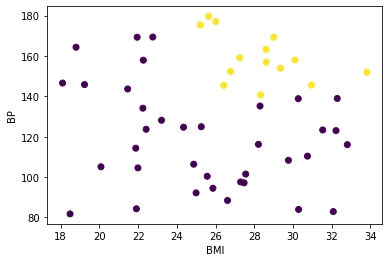

In [3]:
plt.scatter(BMI,BP,c=disease)
plt.xlabel("BMI")
plt.ylabel("BP")
plt.show()

The x axis represents the BMI , the y axis represents the BP 

The yellow dots are the disease samples , now can we use a descision tree to seperate them knowing they are points where BMI>25 and BP>140 ?

here it is :

```python
if BMI > 25:
    if BP>140:
        return "disease"
    else:
        return "no disease"
else:
    return "no disease"
```

Now lets draw a tree :

<img src = 'extras/9.2.PNG'></img>

applying the tree we get

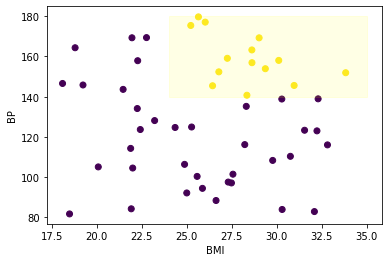

In [4]:
plt.scatter(BMI,BP,c=disease)
plt.fill_between([24,35],[140,140],[180,180], alpha=0.1,color='yellow')
plt.xlabel("BMI")
plt.ylabel("BP")
plt.show()

Getting the intuition leads us to understand the 2 challenges that arise:

1) how to find optimal thresholds (ex: BMI = 25 , BP = 140)

2) How to build set of if-statements of arbitary depth

These details are what make decision trees implementaion challenging

<h1>Math</h1>

We know now that decision trees are basically if statements , but that does not sound machine learn-y enough !!!

what makes it ML is how we choose the conditions which is base on information theory

One key feature of decison trees is that we only look at one attribute at a time

each condition checks only 1 column of X

usually call these "input features" , but usually called "attributes" when talking about DTs

so for ex if we use a persons heights to help us make a decision we might have a decision like :

```python
if (height<5):
    Go to left node
else:
    Go to right node
```

what does this tell us about the geometry of the problem 

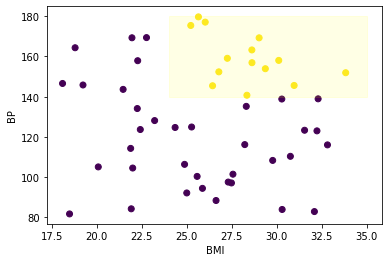

In [5]:
plt.scatter(BMI,BP,c=disease)
plt.fill_between([24,35],[140,140],[180,180], alpha=0.1,color='yellow')
plt.xlabel("BMI")
plt.ylabel("BP")
plt.show()

Lets go back to our disease example 

As we can see the splits are always orthogonal to the axis !!!

whereas linear classifers can create boundaries that are at arbitary angle to the axis decision trees can only seperate data based on lines orthogonal to axis

This doesnot mean we are limited to one side being one thing and the other being another thing , sice we are working with trees now we can have splits at each level , the final decision boundary learned by a decision tree can be highly non-linear 

Each node is a TreeNode object , children are also TreeNode objects

Leaf nodes have no children , when we arrive at leaves we make the prediction

<h1>Math</h1>

Now lets look at the theory behond choosing the best split in a decision tree

we want to choose a split that maximises a reduction is uncertainty

so if we can make a prediction that gets us from being 50% certatin to 100% certain then that is better than making a prediction that gets us from 50% certain to 75% certain

using information theory we can quantify this concept , this is called information wntropy and it is related to variance

recall that a wide variance means we dont know much about the data we will get , but a slim variance means we can be more confident about the data we will get

the equation for information entropy :

$$H(p) = - \sum_x p(x) \log p(x)$$

so it uses the probability distribution over x like variance

this is equal to the expected value of log P

we can see that it will always be positive or zero , since p(x) is between 0 and 1  , -log p(x) will be >= 0

note : when dealing with entropy we usually mean $\log_2$ implicitly

lets take an example , consider a binary variable specifically , 

$p(x=1) = p \ , \ p(X=0) = 1-p $

so the equation of the entopy becomes:

$$H(p) = -p log(p) - (1-p) log (1-p)$$

now what value of p maximises entropy ?

to know that we solve dH/dp = 0 for p , then answer then is p = 0.5

lets make a plot of p(x=1) agains H(p)

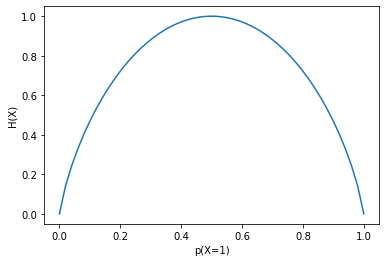

In [6]:
# log(0) and log(1-1) are undefined so we add a very small value 
p = np.linspace(0+(1e-9),1-(1e-9),50)
H_p = -p*np.log2(p) - (1-p)*np.log2(1-p)
plt.plot(p,H_p)
plt.xlabel('p(X=1)')
plt.ylabel('H(X)')
plt.show()

we can clearly see than the peek is at p(x=1) = 0.5

now we can start thinking about themeaning of probability , if the probability of a binary variable = 0.5 , there is no possible way to make a good prediction about it , predict thatever you want , whatever it is , you have a 50% of being right and a 50% of being wrong

consider another value , p = 0.8 , we should always predict 1 since this gives is the best chance of being correct

$Entropy \ is \ a \ measure \ of \ how \ much \ information \ we \ get \ from \ finding \ out \ the \ value \ of \ a \ random \ variable$

meaning , if we flip a coin p = 0.8 and we get heads (1) , we dont gain that much information since we were already 80% certain we would flip heads

however if we flip a cion with p=0.5 heads , and we get heads , we gain the maximum amount of information we could have
 
why ? Because prior to knowing we were maximally clueless about the value we would get

In general the probability distribution that yeilds the maximum entropy is the uniform distribution



<h1>Math</h1>

Now we want to know how do we use information entropy to help us choose thhe best attributes in our data

A common algorithm for implementing decision trees is ID3 , we will give a quick overview of it then talk about how our implementation would differ from it:

ID3:

say we have of all attributes (columns) $S = {\{a_1,a_2,a_k\}}$

find the attribute that best splits data based on having maximum information gain (we will define that shortly) , call it $a(k)$

can split more than once , so each node can have more than 2 children , for ex dice roll would have 6 children

remove a(k) from S , S = S - {a(k)} then repeat split , so once we make a split we can never use that attribute to split again , and all children nodes have to use other attributes to make split

Our Implementation :

we will not require that an attribute can only be used to split once

eg : can go from green to blue than back to green again

this can be useful for problems like the donut problem

Another reason we can use an attribute to split more than once is that each Treenode is going to have 0(if leaf) or 2 children

This will be helpful for data like MNIST , since it will allow us to split at a threshold rather than 256 discrete values

In [7]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
D = 2
R_inner = 5
R_outer = 10

# in a polar system , this is the distance from origin
# we sample from a uniform distribution , set mean to 0
R1 = np.random.randn((N//2)) + R_inner
# and this is the angle
# 2pi * (number from 0-1) so we get thetas between 0-2*pi
theta = 2*np.pi*np.random.random(N//2)
# in a cartesian system x component is R cos theta , y component is R sin theta
X_inner = np.concatenate([[R1*np.cos(theta)],[R1*np.sin(theta)]]).T

R2 = np.random.randn((N//2)) + R_outer
theta = 2*np.pi*np.random.random(N//2)
X_outer = np.concatenate([[R2*np.cos(theta)],[R2*np.sin(theta)]]).T

X = np.concatenate([X_inner , X_outer])
T = np.array([0]*(N//2) + [1]*(N//2))

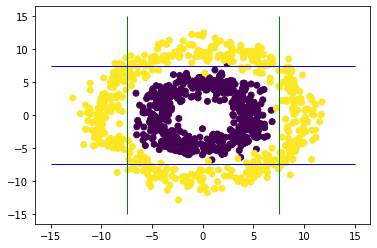

In [8]:
# lets plot the Donuts !!!
plt.scatter(X[:,0],X[:,1],c=T)
plt.fill_between([-7.5,-7.5],[-15,-15],[15,15],alpha=1,color='green')
plt.fill_between([7.5,7.5],[-15,-15],[15,15],alpha=1,color='green')
plt.fill_between([-15,15],[7.5,7.5],[7.5,7.5],alpha=1,color='blue')
plt.fill_between([-15,15],[-7.5,-7.5],[-7.5,-7.5],alpha=1,color='blue')

plt.show()

The above figure is an example of how Descision trees can solve donut problem , our implementation would take advantage of multiple splits and go from yellow to purple then back to yellow again , of course this could be dont verically or horizontally

Now how do we actually calculate information gain

first consider the labels , suppose we have 0,0,1,1

H(Y) = 1

Next , suppose we have an attribute that best splits the data , so for ex , X<0 , Y = 0 , X>0 , Y = 1

of course we should split on this attribute since it gives us a perfect classifier with a 100% accuracy

Then we have the left nodes Y_left = {0,0}

And the right node's Y_right = {1,1}

The entropy of each child is now 0

The total information gain (for this example) is :

$IG(Y|split \ on \  X) = H(Y) - 0.5H(Y_{left}) - 0.5H(Y_{right}) = 1 - 0.5^*0 - 0.5^*0 = 1 $ which is the maximum information gain we can get

the 0.5 here means half the data went to left , half went to right , this Ensuers IG >= 0

Unfortunately data is not always this nice , more likely that not even after the split things still remain misclassified

lets take an example


<table style="width:100%">
  <tr>
    <th>X1</th>
    <th>X2</th>
    <th>Y</th>
  </tr>
  <tr>
    <td>1</td>
    <td>10</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>10</td>
    <td>0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>5</td>
    <td>0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>5</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>5</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2</td>
    <td>5</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2</td>
    <td>10</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2</td>
    <td>10</td>
    <td>1</td>
  </tr>
  <tr>
    <td>1</td>
    <td>10</td>
    <td>1</td>
  </tr>
  <tr>
    <td>1</td>
    <td>10</td>
    <td>0</td>
  </tr>

</table>


we can clearly see that H(Y) = 1 , since there is a 50% of being 0 and a 50% of being 1

lets split X1 now and consider the subset od data where X1 = 1 , and where X2 = 2

X1 = 1 

<table style="width:100%">
    <tr>
        <th>X1</th>
        <th>X2</th>
        <th>Y</th>
    </tr>
    <tr>
        <td>1</td>
        <td>10</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>10</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>5</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>10</td>
        <td>1</td>
    </tr>
      
</table>
    
H(Y|X1 = 1) = -0.75 log (0.75) - 0.25 log (0.25) = 0.811
    
X1 = 2

<table>
    <tr>
        <th>X1</th>
        <th>X2</th>
        <th>Y</th>
    </tr>
    <tr>
        <td>2</td>
        <td>10</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>5</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>5</td>
        <td>1</td>
    </tr>
    <tr>
        <td>2</td>
        <td>5</td>
        <td>1</td>
    </tr>
    <tr>
        <td>2</td>
        <td>10</td>
        <td>1</td>
    </tr>
    <tr>
        <td>2</td>
        <td>10</td>
        <td>1</td>
    </tr>
      
</table>
    
H(Y|X2 = 1) = -(1/3) log (1/3) - (2/3) log (2/3) = 0.918
    

Now if we split on X1:
    
Information gain = 1 - (4/10)(0.811) - (6/10)(0.918) = 0.1248
    
Notice how each of the childs' entropy gets multiplied by the proportion of data it receives , this guarantees that Information gain is always >= 0 


lets see what happens when we split on X2 :

X2 = 5
<table>
    <tr>
        <th>X1</th>
        <th>X2</th>
        <th>Y</th>
    </tr>
    <tr>
        <td>2</td>
        <td>5</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>5</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>5</td>
        <td>1</td>
    </tr>
    <tr>
        <td>2</td>
        <td>5</td>
        <td>1</td>
    </tr>      
</table>
    
H(Y|X2=5) = 1

X2 = 10

<table>
    <tr>
        <th>X1</th>
        <th>X2</th>
        <th>Y</th>
    </tr>
    <tr>
        <td>1</td>
        <td>10</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>10</td>
        <td>0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>10</td>
        <td>0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>10</td>
        <td>1</td>
    </tr>
    <tr>
        <td>2</td>
        <td>10</td>
        <td>1</td>
    </tr>
    <tr>
        <td>1</td>
        <td>10</td>
        <td>1</td>
    </tr>
      
</table>

H(Y|X2=10) = 1

Information gain = 1-(4/10)(1) - (6/10)(1) = 0

since splitting on X1 gives us the highest IG , we should split on X1 first

<h1>Math</h1>

In the previous example it was fairly easy to choose the number to split on , since each of  X1 and X2 had only 2 values 

MNIST data is continuous , how do we pick the split amongst infinite number of splits

we provide some rules to solve this problem :

the first rule is that we onlt need to consider the midpoint betwee any 2 ordered points , since splitting anywhere else between them wont change the entropy

<table>
    <tr>
        <th>X</th>
        <td>0</td>
        <td>1</td>
        <td>2</td>
        <td>3</td>
    </tr>
    <tr>
        <th>Y</th>
        <td>1</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
    </tr>
</table>

split between 1,2 $\to$ 1.5 $\to$ entropy = 1
split at X = 1.75 ? entropy still 1

The next rule is that we need to consider the boundaries between the labels , consider the labels :

Y: 1,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0

if we split at middle , each child has (6/8) in majority class , so the entropy of each child is  :

-(6/8)log(6/8) - (2/8)log(2/8) = 0.8112

Their total weighted entropy = 0.5(0.8112) + 0.5(0.8112) = 0.8112

note that this number ould be deducted from the parents node entropy to get information gain so the higher the number the less information gain

now lets move to the left and repeat

entropy of left child = 

-(2/7)log(2/7) - (5/7)log(5/7) = 0.863

entropy of right child = 

-(3/9)log(3/9) - (6/9)log(6/9) = 0.9183

now Their total weighted entropy = (7/16)(0.863) + (9/16)(0.9183) = 0.8875

we got a higher children entropy and thus less information gain , may be by chance , one more step to the left

entropy of left child = 

-(2/6)log(2/6) - (4/6)log(4/6) = 0.9183

entropy of right child = 

-(4/10)log(4/10) - (6/10)log(6/10) = 0.971

now Their total weighted entropy = (6/16)(0.9183) + (10/16)(0.971) = 0.951

since the left side is the mirror image of the right side , the same thing happens if we go to the right side

it should be clear that the further we move from the boundary , the less the information gain we yeild , so we split only where there is a change in label


so our algorithm would be something like :

sort X's for current columns in order , sort Y in the corresponding way

find all boundary points where Y changes from one value to another

calculate information gain when splitting at each boundary

keep the split which gives the max Information gain

<h1>code</h1>

In [9]:
import numpy as np
from datetime import datetime
import pandas as pd

In [10]:
class node:
    def __init__(self,depth,max_depth):
        # we need to stop at sum max_depth
        # otherwise we overfit , reach a 100% train accuracy but lose general trend of data
        self.depth = depth
        self.max_depth = max_depth
        self.left = None
        self.right = None
        
    def fit(self,X,Y):
        self.p = None
        if self.depth == self.max_depth: # reached max depth , no more splits , predict majority class
            self.p = np.round(Y.mean())
            return
            
        if len(X) == 1 or len(set(Y)) == 1: # all points have same class predict it 
            self.p = Y[0]
            return
        
        # else we can split
        
        # Now we want to find 1) best feature to split on , 2) split point
        # these should give the highest information gain
        max_info_gain = 0
        best_d = None
        best_s = None
        
        for d in range(X.shape[1]):
            X_d = X[:,d]
            # sort X_d , Y 
            idx = np.argsort(X_d)
            X_d = X_d[idx]
            Y_d = Y[idx]
            # get all possible split-points , these are the means of any 2 consecutive x's that have a change in label
            split_points = self.get_split_points(X_d,Y_d)
            # for each split point calculate the information gain , if higher store best_d , and best_split 
            for s in set(split_points):
                left_idx = X_d<s
                info_gain = self.get_info_gain(Y_d,left_idx)
                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    best_d = d
                    best_s = s
        if max_info_gain == 0 : # splitting does no good so simply predict majority class
            self.p = np.round(Y.mean())
            return
        
        
        # now we use best_d and best_s to split data then we form right and left children
        # we save best_d and best_s so we can split the test data when we wish to make prediction
        self.d = best_d
        self.s = best_s
        left_idx = X[:,self.d]<self.s
        
        
        X_left = X[left_idx]
        Y_left = Y[left_idx]

        X_right = X[np.logical_not(left_idx)]
        Y_right = Y[np.logical_not(left_idx)]
        
        
        self.left = node(self.depth+1,self.max_depth)
        self.left.fit(X_left,Y_left)
        
        self.right = node(self.depth+1,self.max_depth)
        self.right.fit(X_right,Y_right)
        

    def predict(self,x):
        if self.p is not None:
            return self.p
        
        d = self.d
        s = self.s
        
        if x[d]<s:
            return self.left.predict(x)
        return self.right.predict(x)
        
    def get_split_points(self,X_d,Y):

        split_points = []
        for i in range(len(Y)-1):
            
            # if there is a change in label between 2 consecutive points
            if Y[i] != Y[i+1]:
                # then add their midpoint as a split point
                split_point = (X_d[i] + X_d[i+1])/2
                split_points.append(split_point)
        return split_points
    
    def entropy(self,Y):
        N = len(Y)
        n0 = len(Y[Y==0])
        n1 = len(Y[Y==1])
        if n0 == N or n1 == N: # all points belong to a single class
            return 0 # so we dont take log(0)
        
        n0 = n0/len(Y)
        n1 = n1/len(Y)
        
        return -n0*np.log2(n0) - n1*np.log2(n1) 
        
    def get_info_gain(self,Y,left_idx):
        # first calculate entropy at this point
        # next we split labels
        Y_left = Y[left_idx]
        Y_right = Y[np.logical_not(left_idx)]
        n_left = len(Y_left)/len(Y)
        n_right = len(Y_right)/len(Y)
        # then return information gain
        return self.entropy(Y) - n_left*self.entropy(Y_left) - n_right*self.entropy(Y_right)

In [11]:
class DecisionTree:
    def fit(self,X,Y,max_depth=None):
        self.root = node(depth=0,max_depth=max_depth)
        self.root.fit(X,Y)
        
    def pred(self,x):
        return self.root.predict(x)
    
    def predict(self,X):
        return np.array([self.pred(x) for x in X])
    
    def score(self,X,Y):
        preds = self.predict(X)
        return np.mean(preds == Y)
    

In [12]:
# we will use the KNN on the MNIST dataset
# https://www.kaggle.com/oddrationale/mnist-in-csv

def get_mnist(limit=None): 
    df = pd.read_csv('datasets/MNIST/train.csv')
    data = df.to_numpy()
    np.random.shuffle(data)
    X = data[:,1:]/255.0
    Y = data[:,0]
    # data is too large , so training would take too much time
    # of course to little data is not good and leads to overfitting
    if limit is not None:
        X,Y = X[:limit] , Y[:limit]
    return X,Y

def get_xor():
    # we will make the XOR grid like before
    N = 200
    X = np.random.random((N, 2))*2 - 1
    # generate labels
    T = np.zeros(N)
    T[(X[:,0] < 0) & (X[:,1] > 0)] = 1
    T[(X[:,0] > 0) & (X[:,1] < 0)] = 1
    return X,T
    
    
# now again for the donut problem 
def get_donut():
    N = 200
    D = 2
    R_inner = 5
    R_outer = 10

    # in a polar system , this is the distance from origin
    # we sample from a uniform distribution , set mean to 0
    R1 = np.random.randn((N//2)) + R_inner
    # and this is the angle
    # 2pi * (number from 0-1) so we get thetas between 0-2*pi
    theta = 2*np.pi*np.random.random(N//2)
    # in a cartesian system x component is R cos theta , y component is R sin theta
    X_inner = np.concatenate([[R1*np.cos(theta)],[R1*np.sin(theta)]]).T

    R2 = np.random.randn((N//2)) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2*np.cos(theta)],[R2*np.sin(theta)]]).T

    X = np.concatenate([X_inner , X_outer])
    T = np.array([0]*(N//2) + [1]*(N//2))
    
    return X,T

In [13]:
X,Y = get_mnist()
# we are doing just binary classification
idx = np.logical_or(Y == 0 , Y == 1)
X = X[idx]
Y = Y[idx]

Ntrain = len(Y)//2

Xtrain,Ytrain = X[:Ntrain] , Y[:Ntrain]
Xtest,Ytest = X[Ntrain:] , Y[Ntrain:]

In [14]:
model = DecisionTree()

t0 = datetime.now()
model.fit(Xtrain, Ytrain)
print("Training time:", (datetime.now() - t0))

t0 = datetime.now()
print("Train accuracy:", model.score(Xtrain, Ytrain))
print("Time to compute train accuracy:", (datetime.now() - t0))

t0 = datetime.now()
print("Test accuracy:", model.score(Xtest, Ytest))
print("Time to compute test accuracy:", (datetime.now() - t0))


Training time: 0:00:13.922181
Train accuracy: 1.0
Time to compute train accuracy: 0:00:00.009015
Test accuracy: 0.9938747731397459
Time to compute test accuracy: 0:00:00.009935
